**This notebook gets us to master_first_classes_with_stats.pkl. This df will be used for classification modeling**

In [459]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Text Cleaning
import re


#Spotify
# Source: https://betterprogramming.pub/how-to-extract-any-artists-data-using-spotify-s-api-python-and-spotipy-4c079401bc37
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time 

# Importing dfs with heavy processing
import pickle

In [460]:
# import peloton data
# Thank you to okaykristinakay on Reddit for the data!
# Source: https://www.reddit.com/r/pelotoncycle/comments/m18xnr/peloton_class_list_march_update/
df = pd.read_excel('../AGF_Peloton Classes March.xlsx')
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl
0,7f66378211c9476b9b5619bf989f91d0,20 min Peace Meditation,A guided meditation that focuses on cultivatin...,4.3333,20,Meditation,23,psny-studio-2,2021-09-03 13:25:00,0.9847,131,Aditi Shah,"To Aditi, yoga goes beyond movement and can br...",Yoga Block,Meditation 22,RIOPY,https://members.onepeloton.com/classes/bootcam...
1,54ac61803b364b2fa8378acd9f593cdb,15 min Bodyweight Strength,"No equipment, no problem. Join us for a high-e...",5.7755,15,Strength,19,psny-studio-3,2021-09-03 13:19:00,0.9933,297,Olivia Amato,"Born and raised in New York, Olivia grew up pl...",Workout Mat,"California Gurls,Let's Get Loud,Let It Rock (f...","Katy Perry,Snoop Dogg,Jennifer Lopez,Kevin Rud...",https://members.onepeloton.com/classes/bootcam...
2,c75fd4831573483c9d45739aae11d083,20 min Focus Flow: Lower Body,This yoga flow class focuses on poses that eng...,4.3664,20,Yoga,23,psny-studio-2,2021-09-03 12:51:00,1.0000,159,Aditi Shah,"To Aditi, yoga goes beyond movement and can br...","Yoga Blanket,Yoga Block,Yoga Mat","Interlude No 1,Oceansize,She Just Likes To Fig...","James Vincent McMorrow,Oh Wonder,Four Tet,Grim...",https://members.onepeloton.com/classes/bootcam...
3,470086936f7a4723ab5a53cb80b571ff,45 min Pop Bootcamp,Split your workout 50/50 between cardio on the...,7.8312,45,Tread Bootcamp,50,psny-studio-4,2021-09-03 11:56:00,0.9737,152,Olivia Amato,"Born and raised in New York, Olivia grew up pl...","Workout Mat,Medium Weights",34+35 (Remix) (feat. Doja Cat & Megan Thee Sta...,"Ariana Grande,Doja Cat,Megan Thee Stallion,Jus...",https://members.onepeloton.com/classes/bootcam...
4,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,None,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...


In [461]:
# Opening pickle files
# Use classId where you can as key for merging
base_clean_df = pd.read_pickle("./base_clean_df.pkl")
artist_df = pd.read_pickle("./artist_df.pkl")
artist_id_class_count = pd.read_pickle("larger_spot_artist_id_class_count.pkl")  # has artist features
songs_df = pd.read_pickle("./songs_df.pkl")
song_class_count_df = pd.read_pickle("./song_class_count_df.pkl")
song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
class_type_reorg_df = pd.read_pickle("./class_type_reorg_df.pkl")
new_class_types_with_artists = pd.read_pickle("./new_class_types_with_artists.pkl")
master_song_df = pd.read_pickle("./master_song_df.pkl") # has song features
# artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# and 40 errors

In [462]:
master_song_df = master_song_df[['peloton_song_name', 'Class Count', 'song_id', 'spotify_song_name', 'album', 'artist',
                                 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability',
                                 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                                 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]

In [463]:
base_clean_df.head()
# Difference from df:
# Dropped null 'instructorBio' rows - only 9
# Dropped rows with null classSongs/classArtists
# Dropped row value with classSongs as float (1 row)
# Populate rows with classType Cycling and classEquipment None to classEquipment = Bike

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl
0,7f66378211c9476b9b5619bf989f91d0,20 min Peace Meditation,A guided meditation that focuses on cultivatin...,4.3333,20,Meditation,23,psny-studio-2,2021-09-03 13:25:00,0.9847,131,Aditi Shah,"To Aditi, yoga goes beyond movement and can br...",Yoga Block,Meditation 22,RIOPY,https://members.onepeloton.com/classes/bootcam...
1,54ac61803b364b2fa8378acd9f593cdb,15 min Bodyweight Strength,"No equipment, no problem. Join us for a high-e...",5.7755,15,Strength,19,psny-studio-3,2021-09-03 13:19:00,0.9933,297,Olivia Amato,"Born and raised in New York, Olivia grew up pl...",Workout Mat,"California Gurls,Let's Get Loud,Let It Rock (f...","Katy Perry,Snoop Dogg,Jennifer Lopez,Kevin Rud...",https://members.onepeloton.com/classes/bootcam...
2,c75fd4831573483c9d45739aae11d083,20 min Focus Flow: Lower Body,This yoga flow class focuses on poses that eng...,4.3664,20,Yoga,23,psny-studio-2,2021-09-03 12:51:00,1.0000,159,Aditi Shah,"To Aditi, yoga goes beyond movement and can br...","Yoga Blanket,Yoga Block,Yoga Mat","Interlude No 1,Oceansize,She Just Likes To Fig...","James Vincent McMorrow,Oh Wonder,Four Tet,Grim...",https://members.onepeloton.com/classes/bootcam...
3,470086936f7a4723ab5a53cb80b571ff,45 min Pop Bootcamp,Split your workout 50/50 between cardio on the...,7.8312,45,Tread Bootcamp,50,psny-studio-4,2021-09-03 11:56:00,0.9737,152,Olivia Amato,"Born and raised in New York, Olivia grew up pl...","Workout Mat,Medium Weights",34+35 (Remix) (feat. Doja Cat & Megan Thee Sta...,"Ariana Grande,Doja Cat,Megan Thee Stallion,Jus...",https://members.onepeloton.com/classes/bootcam...
4,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...


#### Cycling Classes Only

In [464]:
# Create cycling only df
cycling_classes_df = base_clean_df[base_clean_df['classType'] == 'Cycling']

In [465]:
# Reset index
cycling_classes_df.reset_index(drop=True, inplace=True)

In [466]:
# New df
cycling_classes_df

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...
3,241f3dbb523441ac82e8e034d073141e,10 min Cool Down Ride,You've done the hard work! Now take a few extr...,4.1288,10,Cycling,15,psny-studio-1,2021-09-03 01:06:00,0.9944,890,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"How Will I Know,Just Fine,I Wanna Be Down","Whitney Houston,Mary J Blige,Brandy",https://members.onepeloton.com/classes/bootcam...
4,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,9ca70dc29f174f00bee78f2edfc4d1f0,30 min Low Impact Ride,Join Jess for this 30-minute Low Impact Ride e...,6.9919,30,Cycling,33,nyc,18/09/2018 17:19,0.9882,5093,Jess King,Jess is a charismatic instructor with a boundl...,Bike,"Superfly,It Takes Two,The Tears Of A Clown,The...","Curtis Mayfield,Kim Weston,Marvin Gaye,Smokey ...",https://members.onepeloton.com/classes/bootcam...
7406,448dc87b6d5b403f9389814d940b9096,20 min 90s Rock Ride,The 90s were a booming and inventive time in m...,7.0162,20,Cycling,23,nyc,18/09/2018 14:18,0.9796,15857,Matt Wilpers,A former Division I distance runner with 10 ye...,Light Weights,"Loser,Hitchin' A Ride,Song 2,Going Away To Col...","Beck,Green Day,Blur,blink-182,Sublime,Matthew ...",https://members.onepeloton.com/classes/bootcam...
7407,52b8203d0759407db5c3ac0cca19d17e,20 min Climb Ride,Spend the next 20 minutes crushing some hills ...,8.3190,20,Cycling,24,nyc,14/09/2018 13:52,0.9868,4395,Denis Morton,"Raised in Florida, schooled in Tennessee, stee...",Bike,"Drive,More Human Than Human,Got You (Where I W...","Incubus,White Zombie,The Flys,Brick + Mortar,P...",https://members.onepeloton.com/classes/bootcam...
7408,bd89a56c884b48e59ce9c43ab4f4d86f,45 min 90s Pop Ride,The 90s were a booming and inventive time in m...,8.1481,45,Cycling,49,nyc,13/09/2018 23:19,0.9925,1877,Denis Morton,"Raised in Florida, schooled in Tennessee, stee...",Light Weights,"Too Close - Radio Edit,Motownphilly - Original...","Next,Boyz II Men,Blues Traveler,Eagle-Eye Cher...",https://members.onepeloton.com/classes/bootcam...


#### First Classes Only

- Drop not first rides
    - Drop Cool Down Rides
    - Drop FTP Test
    - Drop Live from Home (not good first experience ride - Quarantine rides)
    - Drop Reset
    - Drop Recovery
    - Drop Intro - "how-to" rides

In [467]:
# Drop rides that should not be first rides for experience (cool downs, FTP tests for PZ, etc) - notes above
search_values = ['Cool Down','FTP', 'Live From Home', 'Reset', 'Recovery', 'Intro' , 'Warm Up']
first_classes_df = cycling_classes_df[~cycling_classes_df['className'].str.contains('|'.join(search_values))]
first_classes_df.reset_index(drop=True, inplace=True)

In [468]:
first_classes_df.describe()

,classDifficulty,classDuration,classLength,classRating,classRatingCount
count,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000
mean,7.858991,30.618645,33.952313,0.990695,14483.508377
std,0.778619,11.468559,11.538020,0.006550,16753.337441
min,4.272800,10.000000,12.000000,0.898000,1.000000
25%,7.554450,20.000000,23.000000,0.988400,5081.500000
50%,8.047400,30.000000,33.000000,0.992500,9791.000000
75%,8.378250,45.000000,48.000000,0.995000,17310.500000
max,9.653600,90.000000,93.000000,1.000000,252660.000000


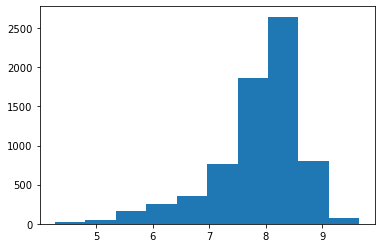

In [469]:
plt.hist(first_classes_df['classDifficulty'])
plt.show()

In [470]:
first_classes_df[[c for c in cycling_classes_df.columns if cycling_classes_df[c].dtype == 'object']].describe()

,classId,className,classDescription,classType,classLocation,classOriginalAirdate,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl
count,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983
unique,6983,548,600,1,6,6910,26,25,2,6975,6973,6983
top,3975418234f3493f9eaa84042917acf4,30 min Intervals & Arms Ride,This class is spent primarily in the saddle to...,Cycling,nyc,2021-02-01 14:00:00,Ben Alldis,"Growing up, Ben was an accomplished athlete wh...",Bike,"Football Fanatic,Are You Gonna Be My Girl,Up A...","Ed Sheeran,Justin Bieber,INXS,Kai,Jack Ü,Skril...",https://members.onepeloton.com/classes/bootcam...
freq,1,353,394,6983,3342,5,588,588,5778,2,2,1


#### Get Roll Up Artist and Song Features Per Class Id

In [471]:
class_playlist_song_medians = pd.DataFrame(columns=['classId','popularity', 'duration_ms', 'explicit', 'danceability',
                               'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                               'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'])

In [472]:
def playlist_song_medians(classSongs, song_feats_df):
    song_list = classSongs.split(",") # Split songs into list
    results = song_feats_df[song_feats_df['peloton_song_name'].isin(song_list)] # look for song data in song_df
    song_list_features = results[['popularity', 'duration_ms', 'explicit', 'danceability', #subset the columns
                                   'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                                   'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
    song_medians_row = pd.DataFrame(song_list_features.median()).T #transpose and create new row
    return song_medians_row

In [473]:
for num in range(0, len(first_classes_df)):
    class_id = first_classes_df.loc[num]['classId'] # Take peloton Class ID, assign variable
    class_songs = first_classes_df.loc[num]['classSongs'] # Look up class songs for class Id (same row)
    new_row = playlist_song_medians(class_songs, master_song_df) # apply playlist_song_medians function
    new_row.insert(0, "classId", class_id)
    new_row_df = pd.DataFrame(new_row)
    frames = [class_playlist_song_medians,new_row_df]
    class_playlist_song_medians = pd.concat(frames) # append row to class_playlist_song_medians df

In [474]:
class_playlist_song_medians.reset_index(drop=True, inplace=True)

In [475]:
class_playlist_song_medians

,classId,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,9680a817bf2149d2b91990c87166a400,65.0,216673.5,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0
1,932f15ed407f46049988ba4c46e3ee3b,33.5,342233.0,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0
2,9319eb174dee4cb081f6491cc81e7c7e,64.0,223776.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0
3,8a8c181b523b430487f6a23bb0436178,60.0,217440.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0
4,8903dfb7bae742a9bd00bf3afd718afa,45.0,228000.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,9ca70dc29f174f00bee78f2edfc4d1f0,59.0,234706.0,0.0,0.5930,0.6070,3.0,-8.7720,1.0,0.05930,0.147000,0.000000,0.0757,0.6500,119.8990,4.0
6979,448dc87b6d5b403f9389814d940b9096,60.0,182747.0,0.0,0.5370,0.7650,8.0,-6.7360,1.0,0.04400,0.012600,0.000129,0.1230,0.6840,129.6990,4.0
6980,52b8203d0759407db5c3ac0cca19d17e,49.5,239826.5,0.0,0.5175,0.7775,6.0,-6.6920,1.0,0.03620,0.001115,0.257500,0.1270,0.5100,121.9470,4.0
6981,bd89a56c884b48e59ce9c43ab4f4d86f,51.5,248273.5,0.0,0.5960,0.7245,7.0,-9.2195,1.0,0.03430,0.025600,0.001474,0.2540,0.6755,107.1820,4.0


In [476]:
class_playlist_song_medians.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000
mean,54.059000,230103.252112,0.061149,0.638908,0.735235,5.398826,-6.681194,0.707504,0.066082,0.091191,0.013195,0.147588,0.569488,120.113810,3.999284
std,12.303262,28461.956806,0.230635,0.083174,0.097838,2.103089,1.784671,0.423431,0.040702,0.106656,0.066108,0.058033,0.143524,12.243193,0.020716
min,0.000000,130537.500000,0.000000,0.237000,0.067800,0.000000,-26.823000,0.000000,0.028400,0.000125,0.000000,0.036700,0.079800,76.208500,3.000000
25%,47.000000,212838.500000,0.000000,0.586000,0.681000,4.000000,-7.564000,0.500000,0.043850,0.026500,0.000005,0.109000,0.470500,112.529250,4.000000
50%,56.000000,227333.000000,0.000000,0.645000,0.747000,5.500000,-6.306000,1.000000,0.053500,0.057100,0.000065,0.132000,0.567000,121.966000,4.000000
75%,63.000000,244087.250000,0.000000,0.695000,0.804000,7.000000,-5.446000,1.000000,0.070100,0.113250,0.000975,0.171000,0.671000,127.075500,4.000000
max,82.000000,525586.500000,1.000000,0.940500,0.969000,11.000000,-2.770000,1.000000,0.434000,0.994000,0.917000,0.940000,0.966000,178.094000,4.000000


In [477]:
class_playlist_artist_medians = pd.DataFrame(columns=['followers', 'popularity'])

In [478]:
def playlist_artist_medians(classArtists, artist_feats_df):
    artist_list = classArtists.split(",")
    results = artist_feats_df[artist_feats_df['name'].isin(artist_list)]
    artist_list_features = results[['followers', 'popularity']]
    artist_medians_row = pd.DataFrame(artist_list_features.median()).T
    return artist_medians_row

In [479]:
for num in range(0, len(first_classes_df)):
    class_id = first_classes_df.loc[num]['classId'] # Take peloton Class ID, assign variable
    class_artists = first_classes_df.loc[num]['classArtists'] # Look up class artists for class Id (same row)
    new_row = playlist_artist_medians(class_artists, artist_id_class_count) # apply playlist_artist_medians function
    new_row.insert(0, "classId", class_id)
    new_row_df = pd.DataFrame(new_row)
    frames = [class_playlist_artist_medians,new_row_df]
    class_playlist_artist_medians = pd.concat(frames) # append row to class_playlist_artist_medians df

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [480]:
class_playlist_artist_medians.reset_index(drop=True, inplace=True)

In [481]:
class_playlist_artist_medians

,classId,followers,popularity
0,9680a817bf2149d2b91990c87166a400,18846591.5,86.0
1,932f15ed407f46049988ba4c46e3ee3b,9809178.0,85.0
2,9319eb174dee4cb081f6491cc81e7c7e,633128.5,67.5
3,8a8c181b523b430487f6a23bb0436178,8877968.0,84.0
4,8903dfb7bae742a9bd00bf3afd718afa,641882.5,63.0
...,...,...,...
6978,9ca70dc29f174f00bee78f2edfc4d1f0,801579.0,61.0
6979,448dc87b6d5b403f9389814d940b9096,1909225.0,72.0
6980,52b8203d0759407db5c3ac0cca19d17e,525552.0,60.0
6981,bd89a56c884b48e59ce9c43ab4f4d86f,737444.5,68.0


In [482]:
class_playlist_artist_medians.describe()

,followers,popularity
count,6.983000e+03,6983.000000
mean,2.890175e+06,73.061149
std,3.390432e+06,7.796079
min,6.600000e+01,9.000000
25%,8.020670e+05,68.500000
50%,1.729150e+06,73.000000
75%,3.677850e+06,79.000000
max,3.348333e+07,94.000000


In [483]:
# Merge Artist and Song median roll ups
class_id_playlist_stats = class_playlist_song_medians.merge(class_playlist_artist_medians, on='classId',how='inner', 
                                                            left_index=True, right_index=True, 
                                                            suffixes=('_song', '_artist'))
class_id_playlist_stats

,classId,popularity_song,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist
0,9680a817bf2149d2b91990c87166a400,65.0,216673.5,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0
1,932f15ed407f46049988ba4c46e3ee3b,33.5,342233.0,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0
2,9319eb174dee4cb081f6491cc81e7c7e,64.0,223776.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5
3,8a8c181b523b430487f6a23bb0436178,60.0,217440.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0
4,8903dfb7bae742a9bd00bf3afd718afa,45.0,228000.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,9ca70dc29f174f00bee78f2edfc4d1f0,59.0,234706.0,0.0,0.5930,0.6070,3.0,-8.7720,1.0,0.05930,0.147000,0.000000,0.0757,0.6500,119.8990,4.0,801579.0,61.0
6979,448dc87b6d5b403f9389814d940b9096,60.0,182747.0,0.0,0.5370,0.7650,8.0,-6.7360,1.0,0.04400,0.012600,0.000129,0.1230,0.6840,129.6990,4.0,1909225.0,72.0
6980,52b8203d0759407db5c3ac0cca19d17e,49.5,239826.5,0.0,0.5175,0.7775,6.0,-6.6920,1.0,0.03620,0.001115,0.257500,0.1270,0.5100,121.9470,4.0,525552.0,60.0
6981,bd89a56c884b48e59ce9c43ab4f4d86f,51.5,248273.5,0.0,0.5960,0.7245,7.0,-9.2195,1.0,0.03430,0.025600,0.001474,0.2540,0.6755,107.1820,4.0,737444.5,68.0


In [484]:
# Merge Artist and Song median roll ups
first_classes_with_stats = first_classes_df.merge(class_id_playlist_stats, on='classId',how='inner', 
                                                  left_index=True, right_index=True)

first_classes_with_stats

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,216673.5,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,342233.0,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,223776.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,217440.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,228000.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,9ca70dc29f174f00bee78f2edfc4d1f0,30 min Low Impact Ride,Join Jess for this 30-minute Low Impact Ride e...,6.9919,30,Cycling,33,nyc,18/09/2018 17:19,0.9882,5093,Jess King,Jess is a charismatic instructor with a boundl...,Bike,"Superfly,It Takes Two,The Tears Of A Clown,The...","Curtis Mayfield,Kim Weston,Marvin Gaye,Smokey ...",https://members.onepeloton.com/classes/bootcam...,59.0,234706.0,0.0,0.5930,0.6070,3.0,-8.7720,1.0,0.05930,0.147000,0.000000,0.0757,0.6500,119.8990,4.0,801579.0,61.0
6979,448dc87b6d5b403f9389814d940b9096,20 min 90s Rock Ride,The 90s were a booming and inventive time in m...,7.0162,20,Cycling,23,nyc,18/09/2018 14:18,0.9796,15857,Matt Wilpers,A former Division I distance runner with 10 ye...,Light Weights,"Loser,Hitchin' A Ride,Song 2,Going Away To Col...","Beck,Green Day,Blur,blink-182,Sublime,Matthew ...",https://members.onepeloton.com/classes/bootcam...,60.0,182747.0,0.0,0.5370,0.7650,8.0,-6.7360,1.0,0.04

In [485]:
# Convert duration milliseconds into minutes
first_classes_with_stats['duration_mins'] = first_classes_with_stats['duration_ms'].map(lambda x: x/60000)

# Drop _ms column
first_classes_with_stats.drop(columns='duration_ms', inplace=True)

#### Class Themes Feature Eng

- Create Class Category for Peloton - map to Cycling categories on Peloton App
    - Beginner = Beginner
    - PZ = Power Zone
    - Live DJ = Live DJ
    - Heart Rate Zone = HRZ
    - Music - year, genres - 0s, Rock, Pop, EDM, Hip Hop, Country, Metal, R&B, Disco, Dance, Broadway, House
    - Pro Cyclist = Pro Cyclist
    - Low Impact = Low Impact, Cool Down, Warm Up, Recovery
    - Climb = Climb
    - Intervals = Intervals, Hills, Tabata
    - Theme - XOXO, Mood Ride
    - Groove - Groove

In [486]:
def label_class_category(className):
    music_names = ['0s', 'Rock', 'Pop', 'EDM', 'Hip Hop', 'Country', 'Metal', 'R&B', 'Disco', 
                   'Dance', 'Broadway', 'House', 'Blues', 'Funk', 'Latin']
    low_impact_names = ['Low Impact', 'Cool Down', 'Warm Up', 'Recovery']
    if 'Beginner' in className:
        return 'Beginner'
    if 'Power Zone' in className:
        return 'Power Zone'
    if 'Live DJ' in className:
        return 'Live DJ'
    if 'HRZ' in className:
        return 'Heart Rate Zone'
    if 'Pro Cyclist' in className:
        return 'Pro Cyclist'
    if 'Climb' in className:
        return 'Climb'
    if 'Groove' in className:
        return 'Groove'
    if 'HIIT' in className or 'Tabata' in className or 'Intervals' in className:  # multiple searches
        return 'Intervals'
    if any(m_name in className for m_name in music_names):
        return 'Music'
    if any(li_name in className for li_name in low_impact_names):
        return 'Low Impact'
    else:
        return 'Theme'

In [487]:
first_classes_with_stats['classCategory'] = first_classes_with_stats['className'].apply(label_class_category)

In [488]:
first_classes_with_stats['classCategory'].value_counts()

Music              3030
Intervals          1709
Theme               743
Low Impact          556
Power Zone          307
Climb               249
Beginner            223
Groove               71
Heart Rate Zone      41
Live DJ              40
Pro Cyclist          14
Name: classCategory, dtype: int64

In [493]:
# # pickle df - done
# first_classes_with_stats.to_pickle("./master_first_classes_with_stats.pkl")

In [490]:
# Bring in artist_df without processing time
first_classes_with_stats = pd.read_pickle("./master_first_classes_with_stats.pkl")

Stats are the median artist and song stats for the playlist on a given ride. This is done to accont for things like:
- cool down songs may be slower
- artist followers can be massive and skew means
- same with popularity on songs - play one drake song and all the stats are skewed higher

Song feature notes from Spotify (https://developer.spotify.com/discover/)
- Mood: Danceability, Valence, Energy, Tempo
- Properties: Loudness, Speechiness, Instrumentalness
- Context: Liveness, Acousticness
- Segments, Tatums, Bars, Beats, Pitches, Timbre, and more

Source: https://medium.com/@boplantinga/what-do-spotifys-audio-features-tell-us-about-this-year-s-eurovision-song-contest-66ad188e112a

- **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


- **Acousticness**: A measure from 0.0 to 1.0 of whether the track is acoustic.


- **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.


- **Instrumentalness**: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.


- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.


- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.


- **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.


- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.


- **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [491]:
first_classes_with_stats.describe()
# Difficulty concentrated 7.5-8.3
# song popularity 54-56
# most playlists not explicit
# danceability .63-.64
# energy .73-.b74
# key 5.3-5.5
# loudness -6.3 - -6.9
# mode .7-1.0
# speechiness .05-.06
# acousticness 0.05-0.09
# instrumentalness .00 - 0.01
# liveness .13-.14
# valence .56
# tempo 120-121
# time sig 4
# followers 1737078 median/ 2905727 mean -- there are high outliers here
# artist popularity 73
# duration_mins = 3.78-3.83 mins

,classDifficulty,classDuration,classLength,classRating,classRatingCount,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
count,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6983.000000,6.983000e+03,6983.000000,6983.000000
mean,7.858991,30.618645,33.952313,0.990695,14483.508377,54.059000,0.061149,0.638908,0.735235,5.398826,-6.681194,0.707504,0.066082,0.091191,0.013195,0.147588,0.569488,120.113810,3.999284,2.890175e+06,73.061149,3.835054
std,0.778619,11.468559,11.538020,0.006550,16753.337441,12.303262,0.230635,0.083174,0.097838,2.103089,1.784671,0.423431,0.040702,0.106656,0.066108,0.058033,0.143524,12.243193,0.020716,3.390432e+06,7.796079,0.474366
min,4.272800,10.000000,12.000000,0.898000,1.000000,0.000000,0.000000,0.237000,0.067800,0.000000,-26.823000,0.000000,0.028400,0.000125,0.000000,0.036700,0.079800,76.208500,3.000000,6.600000e+01,9.000000,2.175625
25%,7.554450,20.000000,23.000000,0.988400,5081.500000,47.000000,0.000000,0.586000,0.681000,4.000000,-7.564000,0.500000,0.043850,0.026500,0.000005,0.109000,0.470500,112.529250,4.000000,8.020670e+05,68.500000,3.547308
50%,8.047400,30.000000,33.000000,0.992500,9791.000000,56.000000,0.000000,0.645000,0.747000,5.500000,-6.306000,1.000000,0.053500,0.057100,0.000065,0.132000,0.567000,121.966000,4.000000,1.729150e+06,73.000000,3.788883
75%,8.378250,45.000000,48.000000,0.995000,17310.500000,63.000000,0.000000,0.695000,0.804000,7.000000,-5.446000,1.000000,0.070100,0.113250,0.000975,0.171000,0.671000,127.075500,4.000000,3.677850e+06,79.000000,4.068121
max,9.653600,90.000000,93.000000,1.000000,252660.000000,82.000000,1.000000,0.940500,0.969000,11.000000,-2.770000,1.000000,0.434000,0.994000,0.917000,0.940000,0.966000,178.094000,4.000000,3.348333e+07,94.000000,8.759775


In [492]:
first_classes_with_stats[[c for c in first_classes_with_stats.columns if first_classes_with_stats[c].dtype == 'object']].describe()

,classId,className,classDescription,classType,classLocation,classOriginalAirdate,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,classCategory
count,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983,6983
unique,6983,548,600,1,6,6910,26,25,2,6975,6973,6983,11
top,3975418234f3493f9eaa84042917acf4,30 min Intervals & Arms Ride,This class is spent primarily in the saddle to...,Cycling,nyc,2021-02-01 14:00:00,Ben Alldis,"Growing up, Ben was an accomplished athlete wh...",Bike,"Football Fanatic,Are You Gonna Be My Girl,Up A...","Ed Sheeran,Justin Bieber,INXS,Kai,Jack Ü,Skril...",https://members.onepeloton.com/classes/bootcam...,Music
freq,1,353,394,6983,3342,5,588,588,5778,2,2,1,3030


## Work with first_classes_with_stats from here on